<a href="https://colab.research.google.com/github/acedesci/scanalytics/blob/master/S11_disruption_management/DT_S11_Module1A_Disruption_Cost_Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

As usual, we start our prescriptive modeling by installing the (i) Pyomo package and (ii) the linear programming solver GLPK (GNU Linear Programming Kit). Please feel free to revisit [Session 9](https://github.com/acedesci/scanalytics/blob/master/S8_9_retail_analytics/S9_Module2A_Retail_Price_Optimization.ipynb) for further information. 

In [0]:
# Install Pyomo and GLPK
!pip install -q pyomo
!apt-get install -y -qq glpk-utils #if GLPK is used
# !apt-get install -y -qq coinor-cbc #if cbc is used

We have performed this step within the past few weeks to gain access to Google Drive for modeling result retrieval and/or storage.

In [2]:
from google.colab import drive
drive.mount('/content/drive')
cwd = '/content/drive/My Drive/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Blocks 1&2: Data input and parameters

We have two different datasets. The latter has more complex configurations, but their structures are similar.

Particularly, each dataset contains a set of scenarios (**inputScenarios**), indicating if supplier *i* ($S_i$) of product *j* ($P_j$) is fully functional/active (1) or disrupted (0). Meanwhile, the set of parameters (**inputParameters**) contains the capacity of each supplier (in **supplierList**), demand for each product (in **productList**), on-hand inventory for each product, the unit loss for the disrupted product and the time-to-recover in the event that a disruption has occurred.

We retrieve those details and rearrange them in the following dictionaries

**supplierCapacityDict** with **key** indicating the supplier in **supplierList**;

**productDemandDict** with **key** indicating the product in **productList**;

**productInvDict** with **key** indicating the product in **productList**;

**productLossDict** with **key** indicating the product in **productList**;

**scenarioTTRDict** for *time-to-recover* with **key** indicating the scenario in **scenarioList**;

**scenarioActiveNodeDict[n][(i,j)]** indicates if supplier *i* for product *j* is active (1) or not (0) for scenario *n* in **scenarioList**, supplier *i* in **supplierList** and product *j* in **productList**.

In [3]:
import pandas
from pyomo.environ import *

# Problem 1 (small scale, one configuration)
urlParameters = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputParameters_Prob1.csv'
urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob1.csv'

# Problem 2 (large scale, 3 possible SC configurations - A, B and C)
urlParameters = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputParameters_Prob2.csv'

# Here are the scenarios under each configuration. The analysis could be done for one SC configuration at a time so only choose one url among them.
urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob2_Config_A.csv'
# urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob2_Config_B.csv'
# urlScenario  = 'https://raw.githubusercontent.com/acedesci/scanalytics/master/S11_disruption_management/inputScenarios_Prob2_Config_C.csv'

# read CSV files
inputScenarios = pandas.read_csv(urlScenario)
inputParameters = pandas.read_csv(urlParameters)

# print(inputScenarios)
# print(inputParameters)

productList = inputParameters.loc[inputParameters['Type']=='Product']['Index'].unique()
supplierList = inputParameters.loc[inputParameters['Type']=='Supplier']['Index'].unique()
scenarioList = inputParameters.loc[inputParameters['Type']=='Disruption']['Index'].unique()

supplierCapacityDict = {}
for i in supplierList:
  cap = inputParameters.loc[(inputParameters['Parameter']=='Capacity') & (inputParameters['Index']==i)]['Value'].values[0]
  supplierCapacityDict[i] = cap

print('Print SupplierCapacityDict')
for key in supplierCapacityDict:
    print(key, ' : ', supplierCapacityDict[key])
print('\n')

productDemandDict = {}
productInvDict = {}
productLossDict = {}

for j in productList:
  dem = inputParameters.loc[(inputParameters['Parameter']=='Demand') & (inputParameters['Index']==j)]['Value'].values[0]
  inv = inputParameters.loc[(inputParameters['Parameter']=='Inventory') & (inputParameters['Index']==j)]['Value'].values[0]
  loss = inputParameters.loc[(inputParameters['Parameter']=='Loss') & (inputParameters['Index']==j)]['Value'].values[0]
  productDemandDict[j] = dem
  productInvDict[j] = inv
  productLossDict[j] = loss

print('Print productDemandDict')
for key in productDemandDict:
    print(key, ' : ', productDemandDict[key])
print('\n')

print('Print productInvDict')
for key in productInvDict:
    print(key, ' : ', productInvDict[key])
print('\n')

print('Print productLossDict')
for key in productLossDict:
    print(key, ' : ', productLossDict[key])
print('\n')

scenarioTTRDict = {}
scenarioActiveNodeDict = {}
for n in scenarioList:
  ttr = inputParameters.loc[(inputParameters['Parameter']=='TTR') & (inputParameters['Index']==n)]['Value'].values[0]
  scenarioTTRDict[n] = ttr
  scenarioActiveNodeDict[n] = {}
  print(str(n)+": avg N. active links = " + str(sum(inputScenarios[n].values)/len(supplierList)))
  
  for ind in range(len(inputScenarios.index)):
    supp = inputScenarios.iloc[ind]['Node']
    prod = inputScenarios.iloc[ind]['Product']
    scenarioActiveNodeDict[n][(supp,prod)] = inputScenarios[n].values[ind]


Print SupplierCapacityDict
Oakville  :  135.0
Windsor  :  105.0
Wayne  :  130.0
Thailand  :  130.0
Romania  :  50.0


Print productDemandDict
Fiesta-1  :  75.0
Fiesta-2  :  60.0
Escape-1  :  35.0
Escape-2  :  30.0
Escape-3  :  30.0
Focus-1  :  150.0
Focus-2  :  100.0
Everest  :  40.0


Print productInvDict
Fiesta-1  :  25.0
Fiesta-2  :  10.0
Escape-1  :  15.0
Escape-2  :  10.0
Escape-3  :  15.0
Focus-1  :  35.0
Focus-2  :  25.0
Everest  :  10.0


Print productLossDict
Fiesta-1  :  2500.0
Fiesta-2  :  3000.0
Escape-1  :  4500.0
Escape-2  :  4750.0
Escape-3  :  5200.0
Focus-1  :  1800.0
Focus-2  :  2200.0
Everest  :  5100.0


Scenario_0: avg N. active links = 2.0
Scenario_1: avg N. active links = 1.8
Scenario_2: avg N. active links = 1.8
Scenario_3: avg N. active links = 1.8
Scenario_4: avg N. active links = 1.8
Scenario_5: avg N. active links = 1.6
Scenario_6: avg N. active links = 1.6
Scenario_7: avg N. active links = 1.8
Scenario_8: avg N. active links = 1.6
Scenario_9: avg N. active 

# Block 3: Create an optimization model

### Block 3.1: Variable declarations

As we all learned in [Session 9](https://github.com/acedesci/scanalytics/blob/master/S8_9_retail_analytics/S9_Module2A_Retail_Price_Optimization.ipynb), an optimization model consists of (i) decision variables, (ii) objective function, and (iii) constraints.

Our decision variables are model.**l** (or $l_j$), which are all nonnegative, denoting the amount of lost demand for product *j* in disruption. For consistency with the paper by Simchi-Levi et al. (2015), on which our modeling is based, we also adopt their notations as follows

productLossDict[j] (or $f_{j}$) denotes the unit for product *j* if its supply is disrupted;

model.**y**$[i, j]$ (or $y_{ij}$) denotes the cumulative production output volume for product *j* at supplier *i*;

scenarioActiveNodeDict[n][(i,j)] (or $\mathcal{S}^{(n)}_{ij}\in\left\{0,1\right\}$) denotes if supplier *i* of product *j* is active (1) under scenario *n*;

productDemandDict[j] (or $d_{j}$) denotes the demand per time unit for product *j*;

scenarioTTRDict[n] (or $t^{(n)}$) denotes the time-to-recover in disruption scenario *n*;

supplierCapacityDict[i] (or $c_{i}$) denotes the capacity level of supplier *i*.


### Block 3.2: Objective function

In this model, we would like to minimize the lost arising from a given disruption scenario, which can be mathematically expressed as follows

$$\min\limits_{l} \left\{ \sum_j f_j \cdot l_j \right\}$$

### Block 3.3: Constraints functions

**Constraint set 1: demand loss for product $j$ **

This set of constraints helps determine the lower bound on the demand lost ($l_j$) during the disruption time ($t^{(n)}$) given the current inventory level ($s_j$) and the cumulative production output for product $j$ from the active link $\mathcal{S}^{(n)}_{ij}=1$.

$$\sum_i \left( \mathcal{S}_{ij} \cdot y_{ij} \right) + l_j \geq d_j \cdot t^{(n)} - s_j, \forall j\in \textbf{productList} $$

**Constraint set 2: capacity at each supplier $i$ **

This set of constraints ensures that the cumulative production output of supplier $i$ is within the capacity of that supplier if it is still active $\left(\mathcal{S}^{(n)}_{ij} \geq 0\right)$.

$$\sum_j \left\{ \mathcal{S}^{(n)}_{ij} \cdot y_{ij} \right\}  \leq c_i \cdot t^{(n)}, \forall j\in \left\{ j\mid \mathcal{S}^{(n)}_{ij} \geq 0\right\} $$

In [4]:
disruptionCost = {}
disruptionResponse = {}
disruptionDemandLoss = {}


resultcolumns = ['disruptionCost', 'lostUnits', 'totalProduction', 'disruptedLinks','activeLinks']
scenarioResults = pandas.DataFrame(columns = resultcolumns, index = scenarioList)

for n in scenarioList:
  print("Analyzing:"+str(n))
  model = ConcreteModel()
  
  # Variables
  model.l = Var(productList, within = NonNegativeReals)
  model.y = Var(supplierList, productList, within = NonNegativeReals)

  model.demandLoss = ConstraintList()
  model.supplierCapacity = ConstraintList()

  # Objective function
  obj_expr = sum(productLossDict[j]*model.l[j] for j in productList)
  # print(obj_expr)
  model.OBJ = Objective(expr = obj_expr, sense = minimize)

  # Constraints 1 calculate demand loss for each product
  for j in productList:
    const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for i in supplierList) + \
                  model.l[j] >= productDemandDict[j]*scenarioTTRDict[n] - productInvDict[j] 
    # print(const_expr)
    model.demandLoss.add(expr = const_expr)

  # Constraints 2 capacity at each supplier i

  for i in supplierList:
    # check if there is any left hand side (i.e., if there is at least one available active link), otherwise pyomo will return an error
    noSupply = True
    for j in productList:
      if scenarioActiveNodeDict[n][(i,j)] > 0: 
        noSupply = False
        break

    # we generate the constraint only if noSupply = False
    if not noSupply:
      const_expr = sum(scenarioActiveNodeDict[n][(i,j)]*model.y[(i,j)] for j in productList) <= supplierCapacityDict[i]*scenarioTTRDict[n]
      #print(const_expr)
      model.supplierCapacity.add(expr = const_expr)

  # Solve the model
  opt = SolverFactory('glpk')
  opt.solve(model) 

  # Save the result for each scenario

  disruptionCost[n] = model.OBJ()
  scenarioResults.loc[n, 'disruptionCost'] = disruptionCost[n]

  disruptionResponse[n] = {}
  nActiveLinks = 0
  for ind in range(len(inputScenarios.index)):
      i = inputScenarios.iloc[ind]['Node']
      j = inputScenarios.iloc[ind]['Product']

      if model.y[(i,j)].value is not None:
        disruptionResponse[n][(i,j)] = model.y[(i,j)].value
        if model.y[(i,j)].value > 0.1:
          nActiveLinks += 1
      else: 
        disruptionResponse[n][(i,j)] = 0

  scenarioResults.loc[n, 'totalProduction'] = sum(disruptionResponse[n].values())
  scenarioResults.loc[n, 'activeLinks'] = nActiveLinks
  scenarioResults.loc[n, 'disruptedLinks'] = len(inputScenarios.index) - sum(scenarioActiveNodeDict[n].values())

  disruptionDemandLoss[n] = {}
  for j in productList:
    disruptionDemandLoss[n][j] = model.l[j].value

  scenarioResults.loc[n, 'lostUnits'] = sum(disruptionDemandLoss[n].values())

  #model.pprint()

  # print("\tDisruption cost: "+str(disruptionCost[n]))
  # print("\tDisruption response: "+str(disruptionResponse[n]))
  # print("\tDemand loss: "+str(disruptionDemandLoss[n]))


Analyzing:Scenario_0
Analyzing:Scenario_1
Analyzing:Scenario_2
Analyzing:Scenario_3
Analyzing:Scenario_4
Analyzing:Scenario_5
Analyzing:Scenario_6
Analyzing:Scenario_7
Analyzing:Scenario_8
Analyzing:Scenario_9
Analyzing:Scenario_10
Analyzing:Scenario_11
Analyzing:Scenario_12
Analyzing:Scenario_13
Analyzing:Scenario_14
Analyzing:Scenario_15
Analyzing:Scenario_16
Analyzing:Scenario_17
Analyzing:Scenario_18
Analyzing:Scenario_19
Analyzing:Scenario_20


       disruptionCost  lostUnits  totalProduction  disruptedLinks  activeLinks
count            21.0       21.0             21.0            21.0         21.0
mean        498,904.8      130.2          1,681.0            31.2          8.0
std         447,350.7      125.8            505.0             0.7          0.8
min               0.0        0.0            785.0            30.0          6.0
10%               0.0        0.0            895.0            31.0          7.0
50%         522,500.0      110.0          1,720.0            31.0          8.0
90%       1,068,500.0      290.0          2,295.0            32.0          9.0
max       1,327,500.0      385.0          2,455.0            33.0          9.0




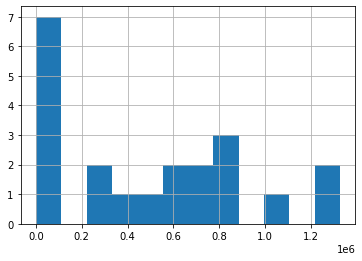

In [5]:
# Intepret and show the results

pandas.options.display.float_format = '{:,.1f}'.format
print(scenarioResults.astype(float).describe(percentiles = [.10, .90]))
print('\n')

%matplotlib inline
import matplotlib.pyplot as plt
scenarioResults['disruptionCost'].astype(int).hist(bins=12)
plt.show()



In [6]:
# show results by scenario

scenarioResults

,disruptionCost,lostUnits,totalProduction,disruptedLinks,activeLinks
Scenario_0,0.0,0.0,"1,415.0",30,9
Scenario_1,"875,000.0",350.0,"2,105.0",31,8
Scenario_2,"561,000.0",110.0,"1,305.0",31,8
Scenario_3,"330,000.0",110.0,785.0,31,8
Scenario_4,"522,500.0",110.0,"1,825.0",31,8
Scenario_5,"1,068,500.0",215.0,"1,720.0",32,7
Scenario_6,"243,000.0",50.0,845.0,32,7
Scenario_7,0.0,0.0,"1,935.0",31,9
Scenario_8,"870,000.0",290.0,"2,165.0",32,8
Scenario_9,"45,000.0",25.0,"1,390.0",31,8
